# Homework 3


In this homework, you will develop an image captioning algorithm by merging CNN and RNN networks. There is no limitation of the architecture or dataset preparation if you meet the requirements as follows (read carefully!):

- You should use [Flick8k dataset](https://www.kaggle.com/adityajn105/flickr8k) from Kaggle. This dataset has both captions and images.
- You should use a pretrained CNN model, but you need to train this model on your dataset for at least **20** epochs - use the techniques learned in the lab with `include_top=False` and possibly change the output layer too if needed.
- You are free to use any Tensorflow API such as Sequential, Functional, or Subclassing API, but you need to be able to explain each code block you create clearly.
This homework aims to make you run the complete deep learning project from scratch, given the dataset, not evaluate your programming skill. This means that you may actively refer to many available online materials. As a starting point, We recommend you to read the following tutorials to understand the problem and model creation techniques better:
 -  https://www.tensorflow.org/tutorials/text/image_captioning (Subclassing API). 
 - https://blog.paperspace.com/image-captioning-with-tensorflow/ (Functional API).
 - We recommend you **not** to use a Subclassing API as it is hard to be free from errors. Also, please note that those tutorials are just starting points, which means that it does not fully satisfy the requirements to pass.
- However, this does not mean that you can copy-paste their results. **Your model should have a novelty**, which means you should not use the exact same models as the examples you can find online.
- We will not evaluate your algorithm based on any performance measure. It will be okay to create a working model that receives images and returns captions.
- You should use at least **two** Tensorflow callbacks when you fit your model. These can be built-in ones or your personalized callback.
- You should use Tensorflow's data API (`tf.data`) to manage your dataset and use `shuffle`, `batch`, and `prefetch` functions.
- Since natural language processing is not covered in our course, you can re-use the preprocessing code snippets from any online materials. This will not be regarded as plagiarism - but you should understand and need to explain everything in the report.
- You should use scikit-learn's `train_test_split` to split the datasets into two parts. Use the ratio of 80% for training.
- You should plot the validation and training accuracy over time using the history output from the `fit` function.
- You should use `dropout` in your network.
- You need to validate your model for each epoch.
- You also need to show five images with created captions from outside the dataset.

You need to submit a short report (2-page max) describing:
 - 1) How you processed the dataset.
 - 2) How you created your model structure.
 - 3) How you trained your model (loss, performance metric ...). 
 - 4) How you meet all the requirements stated above.
  
You do not need to put any working screenshot or code in the report. You should also clearly state the sources if you refer to the internet. You will pass the assignment if you meet all the requirements above and only when you cannot find the code snippets copied from the internet (except for the NLP preprocessing part).

### Library needed

You can specify the libraries you used in this homework here.

In [2]:
import tensorflow as tf
import os
import re
import pandas as pd
import numpy as np
from glob import glob
from numpy import array
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import InceptionV3

### Selected dataset

We will use Flickr8k dataset. Here is a description from Kaggle (https://www.kaggle.com/adityajn105/flickr8k):

A new benchmark collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.

In [3]:
# FLICKR8K
DATA_CAP_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'
DATA_IMG_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'

# DATA SAVE FOLDERS
CAP_FOLDER = '/'
IMG_FOLDER = '/Flicker8k_Dataset/'

### Preprocessing

We will download the dataset from the repository and make it ready to be put into the model. For caption, we may need to apply some preprocessing techniques including tokenization and padding. 

In [4]:
def download_images():
  # Download caption annotation files
  # It's lightweight.. we can download it everytime :P
  cap_zip = tf.keras.utils.get_file('Flickr8k_text.zip',
                                        cache_subdir = os.path.abspath('.'),
                                        origin = DATA_CAP_ORIGIN,
                                        extract = True)
  caption_path = os.path.dirname(cap_zip)+CAP_FOLDER+'Flickr8k.token.txt'

  #REMOVE ZIP THING
  os.remove(cap_zip)
    
  if not os.path.exists(os.path.abspath('.') + IMG_FOLDER):
    image_zip = tf.keras.utils.get_file('Flickr8k_Dataset.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin = DATA_IMG_ORIGIN,
                                        extract = True)
    image_path = os.path.dirname(image_zip) + IMG_FOLDER
    
    #REMOVE ZIP THING
    os.remove(image_zip)

  else:
    image_path = os.path.abspath('.') + IMG_FOLDER

  img_lists = []

  # load image lists
  for imgfile in os.listdir(image_path):
    filename = os.fsdecode(imgfile)
    img_lists.append(image_path+filename)

  return caption_path, image_path, img_lists

This block will save the locations of your images and captions!

In [5]:
caption_path, image_path, img_lists = download_images()

2351104/2340801 [==============================] - 0s 0us/step


In [6]:
caption_path

'c:\\Users\\Kalle\\Desktop\\code\\python\\ML\\HW3/Flickr8k.token.txt'

In [7]:
image_path

'c:\\Users\\Kalle\\Desktop\\code\\python\\ML\\HW3/Flicker8k_Dataset/'

In [8]:
img_lists[1]

'c:\\Users\\Kalle\\Desktop\\code\\python\\ML\\HW3/Flicker8k_Dataset/1000268201_693b08cb0e.jpg'

One example of the dataset :)

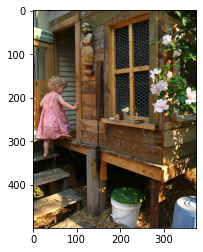

In [9]:
img = mpimg.imread(img_lists[1])
imgplot = plt.imshow(img)
plt.show()

Caption file has both filename and caption. You need to process it a bit so it can have pure captions and the same indices as the images.

In [10]:
captions = open(caption_path, 'r').read().strip().split('\n')

In [11]:
start = '<start> '
end = ' <end>'

data_map = {}
for line in captions:
    token = line.split()
    image_id = token[0].split('#')[0]
    image_caption = ' '.join(token[1:])
        
    if(image_id not in data_map):
        if os.path.isfile(image_path+image_id): # to deal with the one image that isn't working
            data_map[image_path + image_id] =  start + image_caption + end
        
print(data_map[image_path + '1000268201_693b08cb0e.jpg'])
print(data_map[image_path + '1001773457_577c3a7d70.jpg'])
print(len(data_map))

<start> A little girl in a pink dress going into a wooden cabin . <end>
<start> Two dogs on pavement moving toward each other . <end>
8091


In [12]:
# Cleanse and pre-process the data

def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        lines = ''
        for i in value.split():
            if len(i) < 3:
                continue
            i = i.lower()
            lines += i + ' '
        dict_2[key] = lines
    return dict_2

data2 = cleanse_data(data_map)
print(len(data2))   
print(data2[image_path + '1000268201_693b08cb0e.jpg'])
print(data2[image_path + '1001773457_577c3a7d70.jpg']) 
all_images = list(data2.keys())
all_captions = list(data2.values())


8091
<start> little girl pink dress going into wooden cabin <end> 
<start> two dogs pavement moving toward each other <end> 


In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(all_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

token_start = tokenizer.word_index[start.strip()]
token_end = tokenizer.word_index[end.strip()]

all_captions_seq = tokenizer.texts_to_sequences(all_captions)

all_captions_seq = tf.keras.preprocessing.sequence.pad_sequences(all_captions_seq, padding='post')

vocab_size = len(tokenizer.word_index) + 1
max_cap_len = len(all_captions_seq)

### Architectures

The first action might be to generate CNN (our encoder). You may want to use a pretrained architecture in `tf.keras.application`, since it is impossible to train this massive model without good physical machines. After that, we will use the last pooling layer of the architecture without the output layer and link it to an embedded vector (e.g., dimension of 256).

- One thing you should keep in mind when you use a pretrained model, you need to transform your data using the same pre-processing techniques. 

For the decoder, you can use one layer of LSTM or other RNN-based architectures.

**We provide simple steps here, but you do not need to follow all of them as it is your own project to make a working model for image captioning.**

1. You can use scikit-learn's train_test_split to split the datasets into two parts. 

[  2  10 249  17  43  63 260 260   3   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
['<start> young blonde boy jumping from bed bed <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']


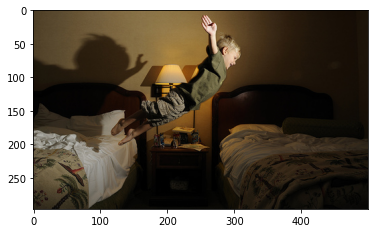

[   2    5 1264   61 2783  572  585  105   67    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
['<start> two athletic girls puma outfits hugging each other <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']


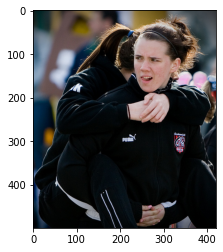

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(all_images, all_captions_seq, test_size=0.2)
print(y_train[1])
print(tokenizer.sequences_to_texts([y_train[1]]))
img = mpimg.imread(X_train[1])
imgplot = plt.imshow(img)
plt.show()
print(y_train[2])
print(tokenizer.sequences_to_texts([y_train[2]]))
img = mpimg.imread(X_train[2])
imgplot = plt.imshow(img)
plt.show()



2. You might want to call your pretrained CNN model and set it up.
 - You can remove the output layer of the pretrained model
 - You can preprocess your dataset using the preprocessing method in the pretrained model.
 - You can finally shuffle, batch, and prefetch your dataset.

In [15]:
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
print(model.layers[-1].output.shape)
print(model.input.shape)
CNN = tf.keras.models.Model(model.input, model.layers[-1].output)
CNN.trainable = False

(None, 2048)
(None, None, None, 3)


In [16]:
def load_preprocess(image):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    return img

def encode(image):
    img = load_preprocess(image)
    pred = CNN(img)
    #print(pred.shape)
    pred = np.reshape(pred, pred.shape[1])
    #print(pred.shape)
    return pred

def encode_all(data):
    output = []
    for img in tqdm(data):
        output.append(encode(img))
    return output

In [17]:
X_train_enc = encode_all(X_train)
X_valid_enc = encode_all(X_valid)

    

  0%|          | 19/6472 [00:03<17:49,  6.03it/s]


KeyboardInterrupt: 

In [ ]:
def map_func(img_encode, cap):
    x = {'text': cap[0:-1],'image': img_encode}
    y = {'output': cap[1:]}
    
    return x,y

In [ ]:
BATCH_SIZE = 64
SHUFFLE_VALUE = 256

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_enc, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_enc, y_valid))
train_dataset = train_dataset.map(map_func)
valid_dataset = valid_dataset.map(map_func)
train_dataset = train_dataset.shuffle(SHUFFLE_VALUE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(SHUFFLE_VALUE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

3. You can create your encoder-decoder structure
 - Encoder: You can connect your last hidden layer of the pretrained model to one FCN of the size you define.
 - Decoder: You can link the encoded values (from FCN) to the RNN network and further develop your model with few more fully connected networks.

In [ ]:
from tensorflow import keras

#encoder
enc_in = keras.layers.Input(shape=(2048,),name='image')
enc_1 = keras.layers.Dropout(0.5)(enc_in)
enc_2 = keras.layers.Dense(512, activation='relu')(enc_1)
enc_3 = keras.layers.Dense(256, activation='relu')(enc_2)
#RNN
dec_in = keras.layers.Input(shape=(None, ), name='text')
dec_1 = keras.layers.Embedding(vocab_size, 512, mask_zero=True)(dec_in)
dec_2 = keras.layers.Dropout(0.5)(dec_1)
dec_3 = keras.layers.GRU(512, return_sequences=True)(dec_2)
dec_4 = keras.layers.Dropout(0.5)(dec_3)
dec_5 = keras.layers.GRU(256, return_sequences=True)(dec_4)
#decoder
dec_mix = keras.layers.add([enc_3, dec_5])
dec_mix_2 = keras.layers.Dense(256, activation='relu')(dec_mix)
dec_mix_3 = keras.layers.Dense(512, activation='relu')(dec_mix_2)
dec_out = keras.layers.Dense(vocab_size, activation='softmax', name='output')(dec_mix_3)

model_1 = keras.models.Model(inputs=[enc_in, dec_in], outputs=[dec_out])

model_1.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 512)    2243072     ['text[0][0]']                   
                                                                                                  
 image (InputLayer)             [(None, 2048)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, None, 512)    0           ['embedding[0][0]']              
                                                                                            

4. You can train your model for at least 20 epochs and plot the loss plot using the history variable.
 - You should also calculate your test performance. 

In [ ]:
model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
    
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
tf.keras.callbacks.LearningRateScheduler(scheduler)]
history = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=20, validation_steps=2)

Epoch 1/20
102/102 [==============================] - 42s 363ms/step - loss: 1.9488 - accuracy: 0.2308 - val_loss: 1.8225 - val_accuracy: 0.2738
Epoch 2/20
102/102 [==============================] - 35s 347ms/step - loss: 1.5991 - accuracy: 0.3031 - val_loss: 1.6173 - val_accuracy: 0.2997
Epoch 3/20
102/102 [==============================] - 35s 347ms/step - loss: 1.4773 - accuracy: 0.3181 - val_loss: 1.7036 - val_accuracy: 0.3093
Epoch 4/20
102/102 [==============================] - 36s 350ms/step - loss: 1.4033 - accuracy: 0.3256 - val_loss: 1.6450 - val_accuracy: 0.3180
Epoch 5/20
102/102 [==============================] - 36s 350ms/step - loss: 1.3443 - accuracy: 0.3326 - val_loss: 1.6965 - val_accuracy: 0.3173
Epoch 6/20
102/102 [==============================] - 36s 349ms/step - loss: 1.3035 - accuracy: 0.3353 - val_loss: 1.7599 - val_accuracy: 0.3372
Epoch 7/20
102/102 [==============================] - 35s 348ms/step - loss: 1.2706 - accuracy: 0.3385 - val_loss: 1.7676 - val_ac

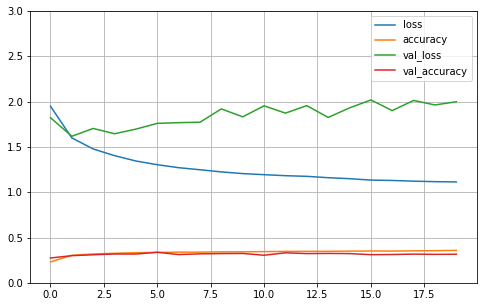

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3) 
plt.show()
model_1.save("my_model.h5")

In [22]:
model_1 = tf.keras.models.load_model("my_model.h5")

5. Evaluation with fun pics
 - Bring five images you like from anywhere, but not from your datasets, and generate captions.

Predicted caption :  the surfer wearing the yellow suit and jumping off the beach <end>


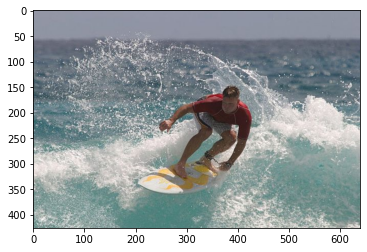

Predicted caption :  the man with the t beard and hat and holding ears and holding balloon bags <end>


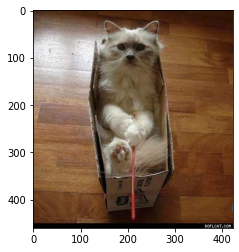

Predicted caption :  the dog running through the grass <end>


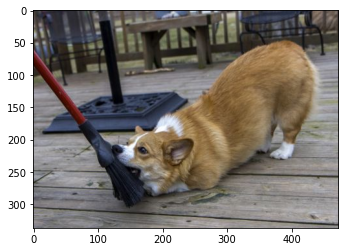

Predicted caption :  the man the bike and riding bike <end>


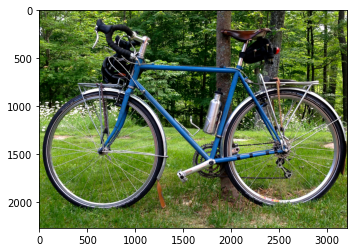

Predicted caption :  the man the white jacket and sandals and dog pulling cart <end>


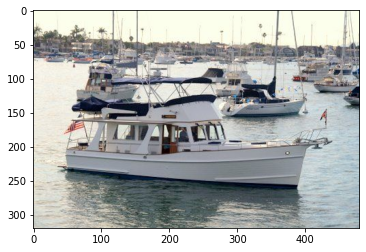

Predicted caption :  the dog running the grass <end>


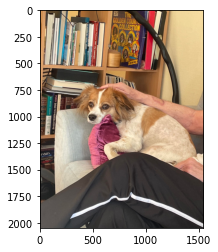

In [23]:
def generate_caption(image_url):
    image = tf.keras.utils.get_file(origin=image_url)
    encoder_input = encode(image)
    encoder_input = np.expand_dims(encoder_input, axis=0)
    shape = (1, max_cap_len)
    decoder_input = np.zeros(shape=shape, dtype=int)
    token_id = token_start
    output=[]
    count_tokens = 0

    while token_id != token_end and count_tokens < max_cap_len:
        decoder_input[0, count_tokens] = token_id
        input_data ={'text' : decoder_input,'image':encoder_input}
        predict = model_1.predict(input_data)
        token_id = np.argmax(predict[0, count_tokens, :])
        output.append(token_id)
        count_tokens += 1
    
    tokenized = tokenizer.sequences_to_texts([output])
    print('Predicted caption : ', tokenized[0])
    x = mpimg.imread(image)
    x = plt.imshow(x)
    plt.show()

generate_caption('https://tensorflow.org/images/surf.jpg')
generate_caption('https://i.pinimg.com/originals/05/d5/0b/05d50bdae37f556cf540ab1b456d559b.jpg')
generate_caption('https://i.pinimg.com/474x/6e/76/96/6e7696bd00cfca3ca3c9955b574e626a.jpg')
generate_caption('https://images.huffingtonpost.com/2014-07-03-Bike.JPG')
generate_caption('https://i.pinimg.com/originals/99/21/6a/99216aa8f2e9af5d1096796e75c9e510.jpg')
generate_caption('https://scontent-arn2-1.xx.fbcdn.net/v/t1.15752-9/274590322_1091233311669740_4994672068209796966_n.jpg?stp=dst-jpg_p1080x2048&_nc_cat=102&ccb=1-5&_nc_sid=ae9488&_nc_ohc=llZJse5GUE4AX-TNruv&_nc_ht=scontent-arn2-1.xx&oh=03_AVKkxamuR214hRYwREMcN23Zu6RJxD9EMAf8WJTgphRYLw&oe=624FD2FE')
